In [4]:
import importlib.util
import os


import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import pytorch_lightning as pl
from sklearn.manifold import TSNE
import glob
import umap

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
import math
from tqdm import tqdm, trange


# import sys; sys.path += ['/Users/tonton/Documents/motion-synthesis']
from modules.motion_VAE_1 import TransformerMotionAutoencoder as Autoencoder
# from encode_motion.src.model import Decoder
from modules.data_modules import MotionDataModule1 as DataModule
# from encode_motion.src.config import config as cfg_ae

In [5]:
activation_dict = {
    'tanh': nn.Tanh(),
    'leaky_relu': nn.LeakyReLU(),
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu': nn.ELU(),
    'swish': nn.SiLU(),
    'mish': nn.Mish(),
    'softplus': nn.Softplus(),
    'softsign': nn.Softsign(),
    # 'bent_identity': nn.BentIdentity(),
    # 'gaussian': nn.Gaussian(),
    'softmax': nn.Softmax(),
    'softmin': nn.Softmin(),
    'softshrink': nn.Softshrink(),
    # 'sinc': nn.Sinc(),
}


class AutoencoderUtility:
    """
    Get the latent space from the auto encoder. 
    """

    def __init__(self, path: str, N: int = 1000, latent_dim: int = -1):
        self.path = path
        print("path:", path)
        if latent_dim == -1:
            latent_dim = cfg_ae.MODEL.latent_dim
        self.latent_dim = latent_dim
        self.N = N

        self.checkpoint_path = self.get_latest_checkpoint()
        # self.checkpoint_path = self.path

    def setup(self):
        self.autoencoder = self.load_autoencoder()
        # self.data, self.z, self.decoded = self.process_data()
        # self.X, self.y, self.z, self.reconstruction = self.process_data()
        # res = self.process_data()
        self.res = self.process_data()
        self.projector, self.projection = self.make_projection(self.res["z"])
        self.get_decorder()


    def get_latest_checkpoint(self):
        return max(
            glob.glob(os.path.join(self.path, "checkpoints", "*")), key=os.path.getctime
        )

    def load_autoencoder(self):
        cfg_ae.MODEL._checkpoint_path = self.checkpoint_path
        cfg_ae.MODEL.load_model = True
    
        autoencoder = Autoencoder(cfg_ae.MODEL)
        # weights = torch.load(self.checkpoint_path)
        # eng_weight_keys = list(weights['state_dict'].keys())[:70]
        # autoencoder.load_state_dict({k: v for k, v in weights['state_dict'].items() if k in eng_weight_keys}, strict=False)
        return autoencoder
    
    def get_decorder(self):
        self.decoder = Decoder(
            hidden_dim=cfg_ae.MODEL.hidden_dim,
            latent_dim=cfg_ae.MODEL.latent_dim,
            seq_len=cfg_ae.DATA.seq_len,
            input_dim=66,
            n_layers=cfg_ae.MODEL.n_layers,
            n_heads=cfg_ae.MODEL.n_heads,
            dropout=cfg_ae.MODEL.dropout,
            hidden_dim_trans=cfg_ae.MODEL.hidden_dim_trans,
            transformer_activation=cfg_ae.MODEL.transformer_activation,
            activation=activation_dict[cfg_ae.MODEL.activation],
        )
        print(f"Loading model from {self.checkpoint_path}")
        # print sum of decoder weights
        weights = self.decoder.state_dict()
        print(sum([torch.sum(v) for k, v in weights.items()]))
        weights = torch.load(self.checkpoint_path)
        # enc_weight_keys = list(weights['state_dict'].keys())[:70]
        dec_weights = {k[8:] : v for k, v in weights['state_dict'].items() if k.startswith('decoder.')}
        print(dec_weights.keys())
        self.decoder.load_state_dict(dec_weights, strict=True)
        print('loaded model from:', self.checkpoint_path)
        print(sum([torch.sum(v) for k, v in self.decoder.state_dict().items()]))
        # this should already have the weights of the trained autoencoder
        

    def process_data(self):
        print("Processing data")
        cfg_ae.DATA.batch_size = self.N
        data_module = DataModule(cfg_ae.DATA)
        # data_module.setup(stage='test')
        # data_loader = data_module.test_dataloader()
        data_module.setup()
        data_loader = data_module.train_dataloader()
        out_puts = {}

        self.idx2word = data_module.idx2word

        self.autoencoder.eval()
        with torch.no_grad():
            for i, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
                
                res = self.autoencoder._common_step(batch, 0, verbose=False)
                z = self.autoencoder.reparametrize(res["mu"], res["logvar"])
                res['z'] = z # latent space
                out_puts[i] = res
                # break
                


        # concatenate the results from each batch
        z = torch.cat([out_puts[i]["z"] for i in out_puts], dim=0)
        motion_seq = torch.cat([out_puts[i]["motion_seq"] for i in out_puts], dim=0)
        recon = torch.cat([out_puts[i]["recon"] for i in out_puts], dim=0)
        text = torch.cat([out_puts[i]["text"] for i in out_puts], dim=0)
        print('data processed')
        return {"z": z, "motion_seq": motion_seq, "recon": recon, 'text': text}
    
    
    def make_projection(self, tensor2d):
        print("Making projection")
        # we use umap, because it is parametric and ca thus be used to project new data
        reducer = umap.UMAP()
        projector = reducer.fit(tensor2d.cpu().detach().numpy())
        projection = projector.transform(tensor2d.cpu().detach().numpy())
    

        # for inv transformation:
        # use projector.inverse_transform(projection)

        print("Projection done")
        return projector, projection

    def plot(self):
        fig = plt.figure(figsize=(15, 6))
        gs = GridSpec(3, 6, figure=fig)

        # add axes
        ax_prodj = fig.add_subplot(gs[:, 2:])
        ax_digits = [fig.add_subplot(gs[i, 0]) for i in range(3)]
        ax_recons = [fig.add_subplot(gs[i, 1]) for i in range(3)]

        # Digit and reconstruction plots
        for i, (ax_d, ax_r) in enumerate(zip(ax_digits, ax_recons)):

            ax_d.imshow(self.X[i].squeeze(), cmap="gray")
            ax_d.set_title(f"Digit {i}")
            ax_d.axis("off")

            ax_r.imshow(self.reconstruction[i].squeeze(), cmap="gray")
            ax_r.set_title(f"Recon {i}")
            ax_r.axis("off")

        scatter = ax_prodj.scatter(
            self.projection[:, 0],
            self.projection[:, 1],
            c=self.y.cpu().detach().numpy(),
            cmap="tab10",
            alpha=0.5,
            s=2,
        )
        ax_prodj.set_xlabel("z1")
        ax_prodj.set_ylabel("z2")
        ax_prodj.set_title("Latent Space")
        fig.colorbar(scatter, ax=ax_prodj, orientation="vertical")

        plt.tight_layout()


def get_latent_space(latent_dim=8, N=100, V=89, plot=False):
    
    utility = AutoencoderUtility(
            path=f"../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_{V}/",
            N=N,
            latent_dim=latent_dim,
        )
    
    save_path = f"../saved_latent/" + '-'.join(utility.checkpoint_path.split("/")[-2:]).split(".")[0]
    # check if saved data exists and load it
    if os.path.exists(save_path):
        print(f"Loading latent space from {save_path}")
        X = torch.load(os.path.join(save_path, "X.pt"))
        z = torch.load(os.path.join(save_path, "z.pt"))
        reconstruction = torch.load(os.path.join(save_path, "reconstruction.pt"))
        projector = torch.load(os.path.join(save_path, "projector.pt"))
        projection = torch.load(os.path.join(save_path, "projection.pt"))
        decoder = torch.load(os.path.join(save_path, "decoder.pt"))
        text = torch.load(os.path.join(save_path, "text.pt"))
        return X, z, reconstruction, projector, projection, decoder, text
    
    else:
        
        utility.setup()
        X = utility.res["motion_seq"]
        reconstruction = utility.res["recon"]
        z = utility.res["z"]
        text = utility.res["text"]
        projector, projection = utility.projector, utility.projection
        decoder = utility.decoder

        # print(decoder)

        #  save the data in ../saved_latent

        os.makedirs(save_path, exist_ok=True)
        # for k, v in zip('X z reconstruction projector projection decoder'.split(), 
        #                 [X, z, reconstruction, projector, projection, decoder]):
        #     torch.save(v, os.path.join(save_path, f"{k}.pt"))

        torch.save(X, os.path.join(save_path, "X.pt"))
        torch.save(z, os.path.join(save_path, "z.pt"))
        torch.save(reconstruction, os.path.join(save_path, "reconstruction.pt"))
        torch.save(projector, os.path.join(save_path, "projector.pt"))
        torch.save(projection, os.path.join(save_path, "projection.pt"))
        torch.save(decoder, os.path.join(save_path, "decoder.pt"))
        torch.save(text, os.path.join(save_path, "text.pt"))

    if plot:
        utility.plot()

    # delete the utility object to free up memory
    del utility
    # del Autoencoder
    # del MNISTDataModule
    return X, z, reconstruction, projector, projection, decoder, text

class LatentSpaceDataModule(pl.LightningDataModule):
    def __init__(self, X, y, batch_size=64):
        super().__init__()
        train_prc, val_prc, test_prc = 0.8, 0.1, 0.1
        indices = torch.randperm(len(X)).tolist()
        train_end = int(train_prc * len(X))
        val_end = train_end + int(val_prc * len(X))
        X_train, X_val, X_test = (
            X[indices[:train_end]],
            X[indices[train_end:val_end]],
            X[indices[val_end:]],
        )

        y_train, y_val, y_test = (
            y[indices[:train_end]],
            y[indices[train_end:val_end]],
            y[indices[val_end:]],
        )

        
        # self.X_train = torch.tensor(X_train)
        # self.X_val = torch.tensor(X_val)
        # self.X_test = torch.tensor(X_test)
        # self.y_train = torch.tensor(y_train).unsqueeze(1)
        # self.y_val = torch.tensor(y_val).unsqueeze(1)
        # self.y_test = torch.tensor(y_test).unsqueeze(1)

        self.X_train = X_train.clone().detach()
        self.X_val = X_val.clone().detach()
        self.X_test = X_test.clone().detach()

        self.y_train = y_train.clone().detach()#.unsqueeze(1)
        self.y_val = y_val.clone().detach()#.unsqueeze(1)
        self.y_test = y_test.clone().detach()#.unsqueeze(1)


        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, self.y_val)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, persistent_workers=True)



if __name__ == "__main__":
    BATCH_SIZE = 200
    X, z, reconstruction, projector, projection, decoder, text = get_latent_space(plot=False, N=200, V=89)
    print('decoder:', decoder)
    dm = LatentSpaceDataModule(z, text, batch_size=BATCH_SIZE)
    dm.setup()

    print("dm:", dm)
    print("dm.train_dataloader:", dm.train_dataloader())
    # get first batch and print shape
    batch_latent, batch_text = next(iter(dm.train_dataloader()))


    # # # decode
    # decoded = decoder(z)
    # # plt.imshow(decoded[0].squeeze().detach().numpy(), cmap="gray")
    # # plt.show(
    
    # print("decoded:", decoded.shape)
    # print("z:", z.shape)
    # print("reconstruction:", reconstruction.shape)
    # print("projection:", projection.shape)
    # print("X:", X.shape)
    # print("x:", x[0].shape)

path: ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_89/


ValueError: max() arg is an empty sequence

In [109]:
import numpy as np
idx2word = np.load('../../data/HumanML3D/HumanML3D/texts_enc/simple/idx2word.npz', allow_pickle=True)['arr_0'].item()
word2idx = np.load('../../data/HumanML3D/HumanML3D/texts_enc/simple/word2idx.npz', allow_pickle=True)['arr_0'].item()



def translate(txt, idx2word):
    return ' '.join([idx2word[i.item()] for i in txt])

def translate_inv(txt, word2idx, max_len=250):
    enc =  [word2idx[i] for i in txt.split()]
    return torch.tensor(enc + [0] * (max_len - len(enc)))

print('Does the encoder work as expected: ',(text[0][0] == translate_inv(translate(text[0][0], idx2word), word2idx)).all())
print(translate(text[0][0], idx2word))


Does the encoder work as expected:  tensor(True)
he takes a few steps forward, then he skips 4 or 5 times.                                                                                                                                                                                                                                             


In [110]:
from utils import plot_3d_motion_animation

plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), translate(text[0][0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon.mp4", velocity=False)
plt.close()

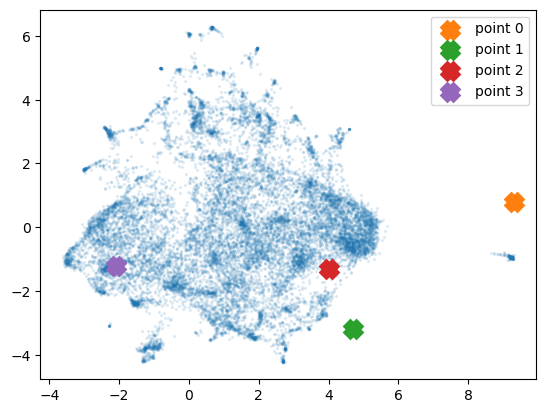

In [111]:
plt.scatter(projection[:, 0], 
            projection[:, 1], 
            # c=range(len(projection)), cmap="tab10", 
            alpha=0.1, s=2)


points = torch.tensor([
    [9.3, .8],
    [4.7,-3.2],
    [4, -1.3],
    [-2.1, -1.2]

]).float()
for i, point in enumerate(points):
    plt.scatter(point[0], point[1], label=f"point {i}", s=100, marker='x', linewidths=8)

plt.legend()

In [112]:
latent_rep = projector.inverse_transform(points)

In [113]:
decoded = decoder(torch.tensor(latent_rep))


decoded.shape

torch.Size([4, 160, 22, 3])

In [114]:
for i, dec in enumerate(decoded):
    plot_3d_motion_animation(dec.cpu().detach().numpy(), "recon", 
                                        figsize=(10, 10), fps=20, radius=2, save_path=f"recon_{i}.mp4", velocity=False)
    plt.close()

# Diffusion model!

*we should pass the text throguh a large language model first to get words like stroll and walk to be similar. () roberta-base*

In [115]:
text.shape, z.shape

(torch.Size([16429, 3, 250]), torch.Size([16429, 1024]))

In [116]:
text_encoded = text.reshape(-1, 250)
# repeat z 3x
latent = z.repeat(3, 1)

text_encoded.shape, latent.shape

(torch.Size([49287, 250]), torch.Size([49287, 1024]))

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math
from tqdm import tqdm

import torchvision

class SimpleModel(nn.Module):
    # a simple model takes (batchsize, latent dim),
    # performs linear layers
    # and returns (batchsize, latent dim)

    def __init__(
        self,
        latent_dim,
        hidden_dim,
        nhidden=5,
        timesteps=1000,
        time_embedding_dim=64,
        target_embedding_dim=5,
        target_size=10054,
        dp_rate=0.1,
    ):
        super(SimpleModel, self).__init__()
        self.time_embedding_dim = time_embedding_dim
        self.target_embedding_dim = target_embedding_dim
        self.time_embedding = nn.Embedding(timesteps, time_embedding_dim)
        self.target_embedding = nn.Embedding(target_size+1, target_embedding_dim, sparse=False)
        # dropout
        self.dropout = nn.Dropout(dp_rate)

        input_dim = 2036
        out_put_dim = latent_dim
        self.fc1 = nn.Linear(
            input_dim, hidden_dim
        )
        
        # input_dim = 11036
        self.fc_hidden = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(nhidden)]
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim),
        )

        # text transformer encoder
        self.text_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=target_embedding_dim,
                nhead=10,
                dim_feedforward=512,
                dropout=0.1,
                activation='relu',
                batch_first=True
            ),
            num_layers=3
        )
        self.text_linear1 = nn.Linear(target_embedding_dim, 4)

    def forward(self, x, y, t):

        # print('x', x.shape, 't', t.shape, 'y', y.shape)
        # print('t', t.shape)
        # print('self.time_embedding', self.time_embedding)
        t = self.time_embedding(t)  # (batchsize, time_embedding_dim)
        # print('t', t.shape)
        # y = y.unsqueeze(1)
        # print('t', t.shape)
        # print('self.target_embedding', self.target_embedding)
        # print('y', y.shape)
        y = self.target_embedding(y)

        y = self.text_transformer(y)
        # print('y', y.shape)
        y = self.text_linear1(y)
        y = nn.Flatten()(y)
        # print('x', x.shape, 't', t.shape, 'y', y.shape)
        # print('self.target_embedding_dim', self.target_embedding_dim)
        

        x = torch.cat([x, t, y], dim=1)
        x = self.fc1(x)
        # print('x', x.shape)
        for layer in self.fc_hidden:
            # x = torch.relu(layer(x))
            x = nn.LeakyReLU()(layer(x))
            x = self.dropout(x)

        x = self.fc2(x)
        return x

class LatentDiffusion(nn.Module):
    def __init__(
        self,
        latent_dim=8,
        hidden_dim=64,
        nhidden=3,
        timesteps=1000,
        time_embedding_dim=64,
        target_embedding_dim=5,
        epsilon=0.008,
        dp_rate=0.1,
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = latent_dim

        betas = self._cosine_variance_schedule(timesteps, epsilon)
        # print('betas', betas.shape)

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        # print('alphas_cumprod', alphas_cumprod.shape)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = SimpleModel(
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            nhidden=nhidden,
            timesteps=timesteps,
            time_embedding_dim=time_embedding_dim,
            target_embedding_dim=target_embedding_dim,
            dp_rate=dp_rate,
        )

    def forward(self, x, y, noise):
        # x:NCHW
        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(x.device)
        # print('t from the LatentDIffusion forward', t)

        x_t = self._forward_diffusion(x, t, noise)

        # print('x_t', x_t.shape, )
        # print('t', t.shape)
        pred_noise = self.model(x_t, y, t)
        # print('pred_noise', pred_noise.shape)

        return pred_noise

    @torch.no_grad()
    def sampling(self, n_samples, clipped_reverse_diffusion=True, device="cuda"):
        x_t = torch.randn(
            (n_samples, self.in_channels, self.image_size, self.image_size)
        ).to(device)
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(x_t).to(device)
            t = torch.tensor([i for _ in range(n_samples)]).to(device)

            if clipped_reverse_diffusion:
                x_t = self._reverse_diffusion_with_clip(x_t, t, noise)
            else:
                x_t = self._reverse_diffusion(x_t, t, noise)

        x_t = (x_t + 1.0) / 2.0  # [-1,1] to [0,1]

        return x_t

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)

        return betas

    def _forward_diffusion(self, x_0, t, noise):
        # print('x_0', x_0.shape)
        # print('noise', noise.shape)
        # print('t', t)

        assert x_0.shape == noise.shape
        # print('self.sqrt_alphas_cumprod.gather(t)', self.sqrt_alphas_cumprod.gather(0,t).shape)
        # q(x_{t}|x_{t-1})

        A = self.sqrt_alphas_cumprod.gather(0, t).unsqueeze(1)
        B = self.sqrt_one_minus_alphas_cumprod.gather(0, t).unsqueeze(1)
        # print('A', A.shape)
        # print('B', B.shape)
        # print('noise', noise.shape)
        # print('x_0', x_0.shape)
        return A * x_0 + B * noise

    @torch.no_grad()
    def _reverse_diffusion(self, x_t, y, t, noise):
        """
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        """
        pred = self.model(x_t, y, t)

        alpha_t = self.alphas.gather(-1, t).reshape(x_t.shape[0], 1)  # ,1,1)
        # print('alpha_t', alpha_t.shape)
        alpha_t_cumprod = self.alphas_cumprod.gather(-1, t).reshape(
            x_t.shape[0], 1
        )  # ,1,1)
        beta_t = self.betas.gather(-1, t).reshape(x_t.shape[0], 1)  # ,1,1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod.gather(
            -1, t
        ).reshape(
            x_t.shape[0], 1
        )  # ,1,1)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_cumprod_t) * pred
        )

        if t.min() > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1, t - 1).reshape(
                x_t.shape[0], 1
            )  # ,1,1)
            std = torch.sqrt(
                beta_t * (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod)
            )
        else:
            std = 0.0

        return mean + std * noise

# make pl model
class LatentDiffusionModel(pl.LightningModule):
    def __init__(
        self,
        decoder,
        **kwargs,
    ):
        super().__init__()
        self.lr = kwargs.get("lr", 0.001)
        self.model = LatentDiffusion(
            latent_dim=kwargs.get("latent_dim", 8),
            hidden_dim=kwargs.get("hidden_dim", 64),
            nhidden=kwargs.get("nhidden", 5),
            timesteps=kwargs.get("timesteps", 100),
            time_embedding_dim=kwargs.get("time_embedding_dim", 8),
            epsilon=kwargs.get("epsilon", 0.008),
            target_embedding_dim=kwargs.get("target_embedding_dim", 8),
            dp_rate=kwargs.get("dp_rate", 0.1),
        )
        self.noise_multiplier = kwargs.get("noise_multiplier", .1)
        # self.save_hyperparameters()
        self.decoder = decoder

    def forward(self, data):
        x, y = data
        # print('x', x.shape)
        # print('y', y.shape)
        # print('x', x.shape, x[0])
        noise = torch.randn_like(x) * self.noise_multiplier
        # print('noise', noise.shape, noise[0])

        # assert False
        # print('x', x.shape)
        # print('noise', noise.shape)
        return self.model(x, y, noise), noise
    
    def _reverse_diffusion(self, x_t, y, t):
        noise = torch.randn_like(x_t)
        return self.model._reverse_diffusion(x_t, y, t, noise)

    def training_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        # print('pred_noise', pred_noise.shape)
        loss = nn.functional.mse_loss(pred_noise, noise)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        loss = nn.functional.mse_loss(pred_noise, noise)


        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        if batch_idx == 0 and self.decoder is not None:
            with torch.no_grad():
                # make image by decoding latent space
                x, y = batch
                # print(x.shape, y.shape)
                pred_clean = x-pred_noise
                x_dirty = x + noise

                raw_reconstruction = self.decoder(x_dirty)
                reconstruction = self.decoder(pred_clean)
                # print('reconstruction', reconstruction.shape)

                # raw_and_recon = torch.cat([raw_reconstruction[:8], reconstruction[:8], ])

                # grid = torchvision.utils.make_grid(raw_and_recon[:16], nrow=8, normalize=True)
                # self.logger.experiment.add_image('top: noisy input, bot: reconstruction', grid, global_step=self.global_step)

                plot_3d_motion_animation(raw_reconstruction[0].cpu().detach().numpy(), translate(y[0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon_dirty.mp4", velocity=False)
                plt.close()

                plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), translate(y[0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon_clean.mp4", velocity=False)
                plt.close()

                

        return loss


    def test_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        loss = nn.functional.mse_loss(pred_noise, noise) / self.noise_multiplier
        self.log(
            "test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

latent_dim = latent.shape[-1]

model = LatentDiffusionModel(
    latent_dim=latent_dim,
    hidden_dim=512,
    nhidden=5,
    timesteps=1000,
    time_embedding_dim=12,
    target_embedding_dim=100,
    epsilon=0.0008,
    dp_rate=0.1,
    decoder=decoder,
    lr = 0.0001,
)

dm = LatentSpaceDataModule(latent, text_encoded, batch_size=BATCH_SIZE)
dm.setup()

# train
trainer = pl.Trainer(max_epochs=100, accelerator='mps')
trainer.fit(model, dm)

# batch = next(iter(dm.train_dataloader()))

# model(batch)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type            | Params
--------------------------------------------
0 | model   | LatentDiffusion | 4.3 M 
1 | decoder | Decoder         | 237 M 
--------------------------------------------
242 M     Trainable params
0         Non-trainable params
242 M     Total params
968.176   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Predict

In [138]:
# predict text input
text_input = 'jumping jacks'

text_enc_input = translate_inv(text_input, word2idx).unsqueeze(0)
noisy_latent = (torch.randn_like(latent[0]) * 8.0).unsqueeze(0)
print('text_enc_input', text_enc_input.shape)
print('noisy_latent', noisy_latent.shape)
# pred_noise, noise = model((noisy_latent.unsqueeze(0), text_enc_input.unsqueeze(0)))
print(noisy_latent.sum())
# # subtact pred
t = 9
out = noisy_latent.clone().to(torch.device('mps'))
for i in range(t, 1, -1):
    print(i, end='\r')
    out = model._reverse_diffusion(out.to(torch.device('mps')),
                                   text_enc_input.to(torch.device('mps')),
                                   torch.tensor([i]).to(torch.device('mps')) )
    # print(noisy_latent.shape)

print(noisy_latent.sum())
print(out.sum())
# decode
reconstruction = decoder(out)
recon_noisy = decoder(noisy_latent.to(torch.device('mps')))
print(reconstruction.shape)

plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), text_input,
                                        figsize=(10, 10), fps=20, radius=2, save_path=f"recon_text.mp4", velocity=False)
plt.close()

plot_3d_motion_animation(recon_noisy[0].cpu().detach().numpy(), text_input,
                                        figsize=(10, 10), fps=20, radius=2, save_path=f"recon_text_noisy.mp4", velocity=False)
plt.close()



text_enc_input torch.Size([1, 250])
noisy_latent torch.Size([1, 1024])
tensor(-4.6442)
tensor(-4.6442)
tensor(-5.2164, device='mps:0')
torch.Size([1, 160, 22, 3])


In [123]:
torch.tensor([i]).to(noisy_latent.device).device

device(type='cpu')